In [1]:
import torch
import numpy as np
import phi.torch.flow as ptf

device = torch.device('cuda')

In [2]:
index1 = 10
index2 = 11
filename1 = f'../ret/phiflow_{index1:03d}.npz'
filename2 = f'../ret/phiflow_{index2:03d}.npz'
den1_np = np.load(filename1)['density']
den2_np = np.load(filename2)['density']
den1_gpu = torch.tensor(den1_np, dtype=torch.float32, device=device)
den2_gpu = torch.tensor(den2_np, dtype=torch.float32, device=device)

In [3]:
print(den1_gpu.shape)
print(den2_gpu.shape)

torch.Size([100, 100, 100])
torch.Size([100, 100, 100])


In [4]:
BOUNDS = ptf.Box(x=1, y=1, z=1)
RESOLUTION = 100
DENSITY1 = ptf.CenteredGrid(
    values=ptf.wrap(den1_gpu, ptf.spatial('x,y,z')),
    extrapolation=ptf.extrapolation.ZERO,
    bounds=BOUNDS,
    resolution=ptf.spatial(x=RESOLUTION, y=RESOLUTION, z=RESOLUTION),
)
DENSITY2 = ptf.CenteredGrid(
    values=ptf.wrap(den2_gpu, ptf.spatial('x,y,z')),
    extrapolation=ptf.extrapolation.ZERO,
    bounds=BOUNDS,
    resolution=ptf.spatial(x=RESOLUTION, y=RESOLUTION, z=RESOLUTION),
)

INFLOW = ptf.CenteredGrid(
    values=ptf.Sphere(center=ptf.tensor([0.5, 0, 0.5], ptf.channel(vector='x,y,z')), radius=0.05),
    extrapolation=ptf.extrapolation.ZERO,
    bounds=BOUNDS,
    resolution=ptf.spatial(x=RESOLUTION, y=RESOLUTION, z=RESOLUTION),
)

In [5]:
vel_x_gpu = torch.zeros(101, 100, 100, dtype=torch.float32, device=device, requires_grad=True)
vel_y_gpu = torch.zeros(100, 101, 100, dtype=torch.float32, device=device, requires_grad=True)
vel_z_gpu = torch.zeros(100, 100, 101, dtype=torch.float32, device=device, requires_grad=True)
vel_x_wrap = ptf.wrap(vel_x_gpu, ptf.spatial('x,y,z'))
vel_y_wrap = ptf.wrap(vel_y_gpu, ptf.spatial('x,y,z'))
vel_z_wrap = ptf.wrap(vel_z_gpu, ptf.spatial('x,y,z'))
VELOCITY = ptf.StaggeredGrid(
    values=ptf.math.stack([vel_x_wrap, vel_y_wrap, vel_z_wrap], ptf.dual(vector='x,y,z')),
    extrapolation=ptf.extrapolation.ZERO_GRADIENT,
    bounds=BOUNDS,
    resolution=ptf.spatial(x=RESOLUTION, y=RESOLUTION, z=RESOLUTION),
)

In [6]:
@ptf.jit_compile
def step(v, s, dt, ir, inflow):
    s = ptf.advect.mac_cormack(s, v, dt) + ir * ptf.resample(inflow, to=s, soft=True)
    return s


delta_time = 0.2
inflow_rate = 0.2

In [7]:
params = [vel_x_gpu, vel_y_gpu, vel_z_gpu]
optimizer = torch.optim.RAdam(params, lr=0.001)

In [8]:
import tqdm

losses = []
mask = (DENSITY1.values.native('x,y,z') < 0.01).bool()
for _ in tqdm.trange(500):
    optimizer.zero_grad()
    ret = step(VELOCITY, DENSITY1, delta_time, inflow_rate, INFLOW)
    loss_mse = torch.nn.functional.mse_loss(DENSITY2.values.native('x,y,z'), ret.values.native('x,y,z'))
    loss_velocity_penalty = 100 * torch.norm(VELOCITY.at_centers().values.native('x,y,z, vector')[mask], dim=-1).mean()
    loss = loss_mse + loss_velocity_penalty
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

100%|██████████| 1000/1000 [05:45<00:00,  2.89it/s]


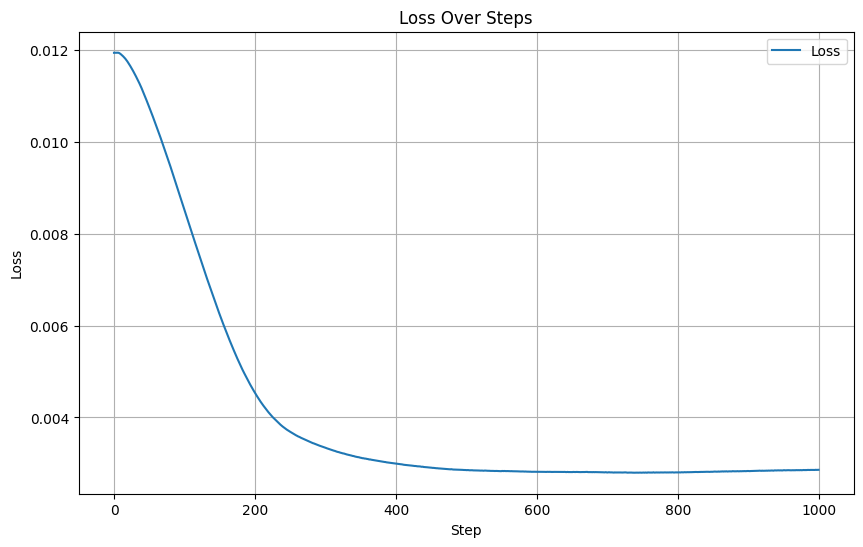

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1000), losses, label='Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss Over Steps')
plt.legend()
plt.grid()
plt.show()

In [10]:
vel_result_np = VELOCITY.at_centers().numpy()
np.save('vel_result.npy', vel_result_np)

In [11]:
den_result_np = step(VELOCITY, DENSITY1, delta_time, inflow_rate, INFLOW).numpy()
np.save('den_result.npy', den_result_np)

In [12]:
den_start_np = DENSITY1.numpy()
np.save('den_start.npy', den_start_np)